# Crop Yield Prediction: PyTorch Neural Network

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Tools for visualizing Optuna results
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Making the plots look a bit nicer
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Check if I have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cool, running on: {device}")

Cool, running on: cpu


### 1. Loading Data & Picking the Target
Loading the dataset and picking which crop to predict. I'll stick with **Rice** for now, but it's easy to change.

In [16]:
# Load the data
df = pd.read_parquet('Parquet/XY_v3.parquet')

# --- CHECKING OPTIONS ---
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("Here are the available crops:")
print(available_crops)
print("-" * 40)

# --- CHOOSE CROP HERE ---
CHOSEN_CROP = 'rice'  # <--- Change this to 'lettuce', 'maize', etc. to test others
# ---------------------------

TARGET_COL = f'Y_{CHOSEN_CROP}'

if TARGET_COL not in df.columns:
    raise ValueError(f"Can't find {TARGET_COL}. Check the spelling?")

print(f"Locked in target: {TARGET_COL}")

# Drop rows where the target is missing
df_model = df.dropna(subset=[TARGET_COL])
print(f"Valid data points found: {len(df_model)}")

Here are the available crops:
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Locked in target: Y_rice
Valid data points found: 4687


### 2. Cleaning & Prep
I'm removing the absolute min and max yield rows for each country—just to get rid of extreme outliers that might confuse the training.

Then, I'm splitting the data by time (Train < 2014, Val 2014-2018, Test >= 2019) and scaling the features.

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd

# --- Remove min/max outliers per country ---
df_model = df_model.copy()

# Find indices for min and max yields
idx_min = df_model.groupby('area')[TARGET_COL].idxmin().values
idx_max = df_model.groupby('area')[TARGET_COL].idxmax().values

# Combine them
rows_to_drop = np.concatenate([idx_min, idx_max])

# Drop them
df_model = df_model.iloc[~df_model.index.isin(rows_to_drop)].reset_index(drop=True)
print(f"Data count after cleaning outliers: {len(df_model)}")

# --- DROP IRRELEVANT COLUMNS ---
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]
df_model = df_model.drop(columns=cols_to_drop)

# --- SETUP FEATURES ---
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

print(f"Total input features: {len(feature_cols)}")

# --- TIME-BASED SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# 1. Train (< 2014)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train_raw = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation (2014 - 2018)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val_raw = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test (>= 2019)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test_raw = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

# --- FILL MISSING VALUES ---
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_raw), columns=feature_cols)
X_val_imputed = pd.DataFrame(imputer.transform(X_val_raw), columns=feature_cols)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_raw), columns=feature_cols)

# --- NORMALIZE (SCALE) ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_imputed)
X_val = scaler.transform(X_val_imputed)
X_test = scaler.transform(X_test_imputed)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples:       {len(X_test)}")

Data count after cleaning outliers: 4441
Total input features: 17

Training samples: 3383
Validation samples: 541
Test samples:       517


### 3. First Try (Initial Model)
I'll define a simple network and run it just to see if the pipeline works without crashing. I'll check the metrics on all splits.

Epoch 0/150 -> Train RMSE: 3824.48 | Val RMSE: 4560.07
Epoch 50/150 -> Train RMSE: 550.89 | Val RMSE: 491.90
Epoch 100/150 -> Train RMSE: 522.67 | Val RMSE: 441.64
Epoch 149/150 -> Train RMSE: 510.19 | Val RMSE: 439.51


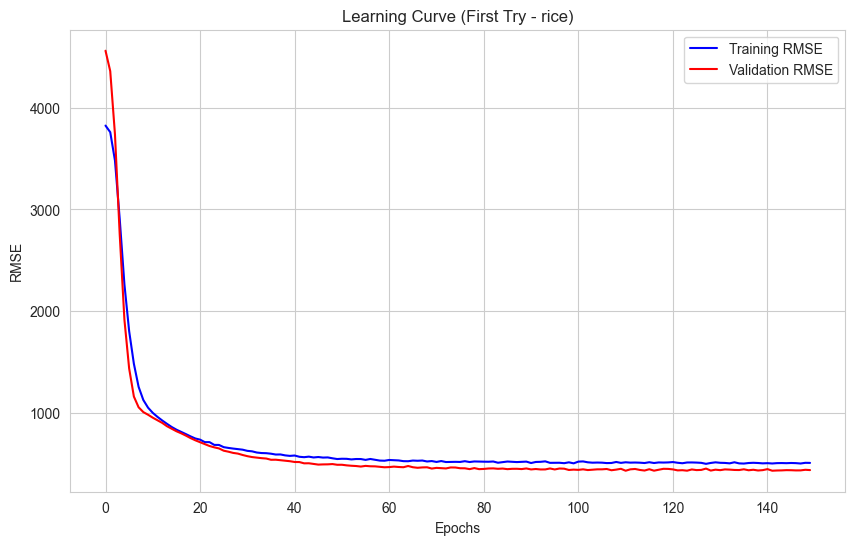


--- Initial Model Performance ---


,Metric,Train,Validation,Test
0,RMSE,474.701271,439.514327,471.094633
1,R²,0.933412,0.959108,0.952574


In [18]:
# --- DEFINE THE NETWORK ---
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

# --- TRAINING HELPER FUNCTION ---
def train_model(model, X_t, y_t, X_v, y_v, lr=0.001, epochs=150, batch_size=32, verbose=True):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
            
        # Calculate metrics
        train_rmse = np.sqrt(epoch_loss / len(X_t))
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_v)
            val_loss = criterion(val_outputs, y_v)
            val_rmse = np.sqrt(val_loss.item())
            
        train_losses.append(train_rmse)
        val_losses.append(val_rmse)
        
        if verbose and (epoch % 50 == 0 or epoch == epochs-1):
            print(f"Epoch {epoch}/{epochs} -> Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}")
            
    return train_losses, val_losses

# --- RUNNING THE INITIAL MODEL ---
input_dim = X_train.shape[1]
# Renamed from 'model_init' to 'init_model' for consistency
init_model = SimpleNN(input_dim).to(device)

# Training with standard settings
train_hist, val_hist = train_model(init_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
                                   lr=0.001, epochs=150, batch_size=32)

# --- PLOTTING HISTORY ---
plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Training RMSE', color='blue')
plt.plot(val_hist, label='Validation RMSE', color='red')
plt.title(f'Learning Curve (First Try - {CHOSEN_CROP})')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# --- EVALUATION TABLE ---
def get_metrics(model, X, y_true):
    model.eval()
    with torch.no_grad():
        preds = model(X).cpu().numpy().flatten()
    y_true_np = y_true
    # Handle tensor vs numpy
    if isinstance(y_true, torch.Tensor):
        y_true_np = y_true.cpu().numpy().flatten()
        
    rmse = np.sqrt(mean_squared_error(y_true_np, preds))
    r2 = r2_score(y_true_np, preds)
    return rmse, r2, preds

# Get stats for all sets
# Using 'init_' prefix for clarity
rmse_t, r2_t, _ = get_metrics(init_model, X_train_tensor, y_train_tensor)
rmse_v, r2_v, _ = get_metrics(init_model, X_val_tensor, y_val_tensor)
rmse_init_test, r2_init_test, preds_init_test = get_metrics(init_model, X_test_tensor, y_test)

# Show results
metrics_data = {
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_t, r2_t],
    'Validation': [rmse_v, r2_v],
    'Test': [rmse_init_test, r2_init_test]
}
print("\n--- Initial Model Performance ---")
display(pd.DataFrame(metrics_data))

### 4. Hyperparameter Tuning (Optuna)
Now the fun part. I'm using Optuna to find the best configuration (number of units, dropout, learning rate, etc.).

In [19]:
# --- FLEXIBLE MODEL FOR OPTUNA ---
class DynamicNN(nn.Module):
    def __init__(self, input_dim, n_layers, n_units, dropout, activation_name):
        super(DynamicNN, self).__init__()
        layers = []
        in_features = input_dim
        
        # Choose Activation Function
        if activation_name == "ReLU":
            act_fn = nn.ReLU()
        elif activation_name == "LeakyReLU":
            act_fn = nn.LeakyReLU()
        else:
            act_fn = nn.ReLU()

        # Stack Layers
        for _ in range(n_layers):
            layers.append(nn.Linear(in_features, n_units))
            layers.append(act_fn)
            layers.append(nn.Dropout(dropout))
            in_features = n_units
            
        layers.append(nn.Linear(in_features, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- OBJECTIVE FUNCTION ---
def objective(trial):
    # Defining the search space
    n_layers = trial.suggest_int("n_layers", 3, 3)   # Keeping this fixed for now
    n_units = trial.suggest_int("n_units", 32, 48)   # Trying values around 42
    dropout = trial.suggest_float("dropout", 0.14, 0.18)
    lr = trial.suggest_float("lr", 0.0006, 0.0010, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16])
    activation = trial.suggest_categorical("activation", ["LeakyReLU", "ReLU"])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])

    # Build model with these params
    model = DynamicNN(input_dim, n_layers, n_units, dropout, activation).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
        
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), 
                              batch_size=batch_size, shuffle=True)
    
    # Quick training loop
    epochs = 40 # Keeping epochs lower for speed during tuning
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_rmse = np.sqrt(criterion(val_pred, y_val_tensor).item())

        # Pruning mechanism (stops bad trials early)
        trial.report(val_rmse, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_rmse

# --- START TUNING ---
study = optuna.create_study(direction='minimize', study_name='Crop_Yield_NN_Optuna')
study.optimize(objective, n_trials=30)

print("\nFound the best settings:")
print(study.best_params)

[I 2025-12-09 14:33:13,778] A new study created in memory with name: Crop_Yield_NN_Optuna
[I 2025-12-09 14:33:17,394] Trial 0 finished with value: 453.8412442694031 and parameters: {'n_layers': 3, 'n_units': 48, 'dropout': 0.177451699487057, 'lr': 0.0006243330154694193, 'batch_size': 16, 'activation': 'LeakyReLU', 'optimizer': 'Adam'}. Best is trial 0 with value: 453.8412442694031.
[I 2025-12-09 14:33:20,600] Trial 1 finished with value: 453.81001669200737 and parameters: {'n_layers': 3, 'n_units': 43, 'dropout': 0.14904903979248707, 'lr': 0.0008237737878984415, 'batch_size': 16, 'activation': 'LeakyReLU', 'optimizer': 'Adam'}. Best is trial 1 with value: 453.81001669200737.
[I 2025-12-09 14:33:23,866] Trial 2 finished with value: 449.1138844992437 and parameters: {'n_layers': 3, 'n_units': 41, 'dropout': 0.1490805079206063, 'lr': 0.000682779152423467, 'batch_size': 16, 'activation': 'LeakyReLU', 'optimizer': 'Adam'}. Best is trial 2 with value: 449.1138844992437.
[I 2025-12-09 14:33:2


Found the best settings:
{'n_layers': 3, 'n_units': 38, 'dropout': 0.168796363817756, 'lr': 0.000720060695429866, 'batch_size': 8, 'activation': 'ReLU', 'optimizer': 'Adam'}


### 5. Optuna Visuals
Let's look at the charts to see how the optimization process went and which parameters mattered most.

In [20]:
# Optimization History
fig = plot_optimization_history(study)
fig.show()

# Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.show()
except:
    print("Oops, couldn't plot importance.")

### 6. Training the Final Model
I'll take the best parameters from Optuna and train a fresh model. This time, I'll combine the Training and Validation sets to give the model maximum data before the final Test.

In [21]:
# Combine Train and Validation Data
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))

X_train_full_tensor = torch.tensor(X_train_full, dtype=torch.float32).to(device)
y_train_full_tensor = torch.tensor(y_train_full, dtype=torch.float32).view(-1, 1).to(device)

bp = study.best_params

final_model = DynamicNN(
    input_dim,
    bp['n_layers'], 
    bp['n_units'], 
    bp['dropout'], 
    bp['activation']
).to(device)

optimizer = optim.Adam(final_model.parameters(), lr=bp['lr'])
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train_full_tensor, y_train_full_tensor), 
                          batch_size=bp['batch_size'], shuffle=True)

print("Training the final version now...")
final_model.train()
for epoch in range(150):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

print("Finished!")

Training the final version now...
Finished!


### 7. Results & Comparison
Let's see the numbers. I'll compare the Initial Model side-by-side with the Tuned Model.

--- Final Tuned Model Metrics ---


,Metric,Train,Validation,Test
0,RMSE,486.288832,424.436906,445.568730
1,R²,0.930122,0.961865,0.957575


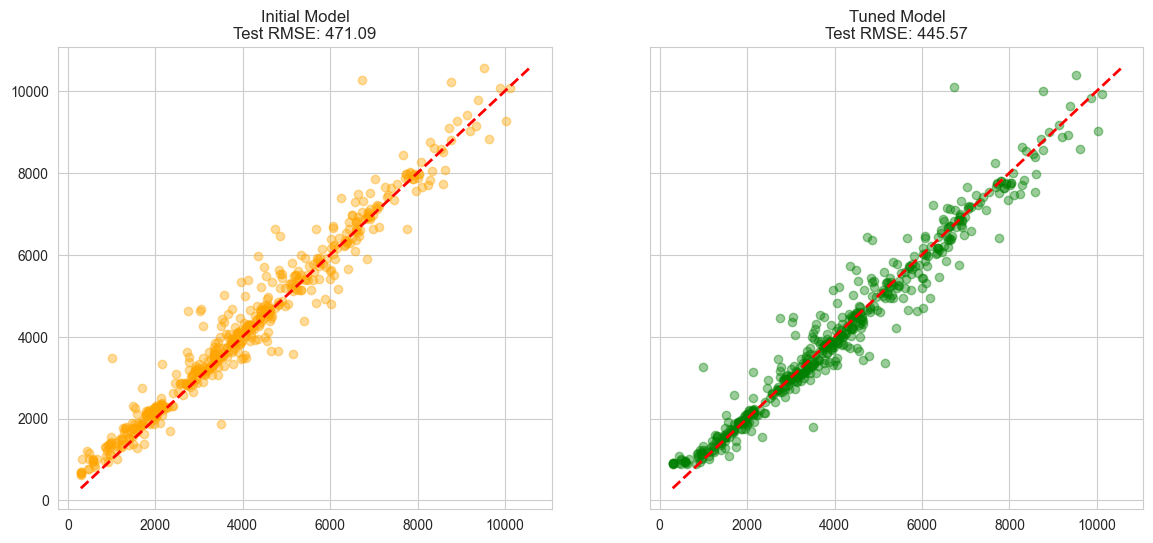

In [22]:
# Evaluate Final Model
# Note: Evaluating 'Train' and 'Val' on original splits for consistent comparison,
# even though the model saw the Val data during training this time.
rmse_f_t, r2_f_t, _ = get_metrics(final_model, X_train_tensor, y_train_tensor)
rmse_f_v, r2_f_v, _ = get_metrics(final_model, X_val_tensor, y_val_tensor)
rmse_final_test, r2_final_test, preds_final_test = get_metrics(final_model, X_test_tensor, y_test)

metrics_final = {
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_f_t, r2_f_t],
    'Validation': [rmse_f_v, r2_f_v],
    'Test': [rmse_final_test, r2_final_test]
}

print("--- Final Tuned Model Metrics ---")
display(pd.DataFrame(metrics_final))

# --- PLOT COMPARISON ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

all_preds = np.concatenate([preds_init_test, preds_final_test])
all_true = np.concatenate([y_test, y_test])
min_val, max_val = min(all_preds.min(), all_true.min()), max(all_preds.max(), all_true.max())

# Initial Model Plot
axes[0].scatter(y_test, preds_init_test, alpha=0.4, color='orange')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Initial Model\nTest RMSE: {rmse_init_test:.2f}')

# Tuned Model Plot
axes[1].scatter(y_test, preds_final_test, alpha=0.4, color='green')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Tuned Model\nTest RMSE: {rmse_final_test:.2f}')

plt.show()

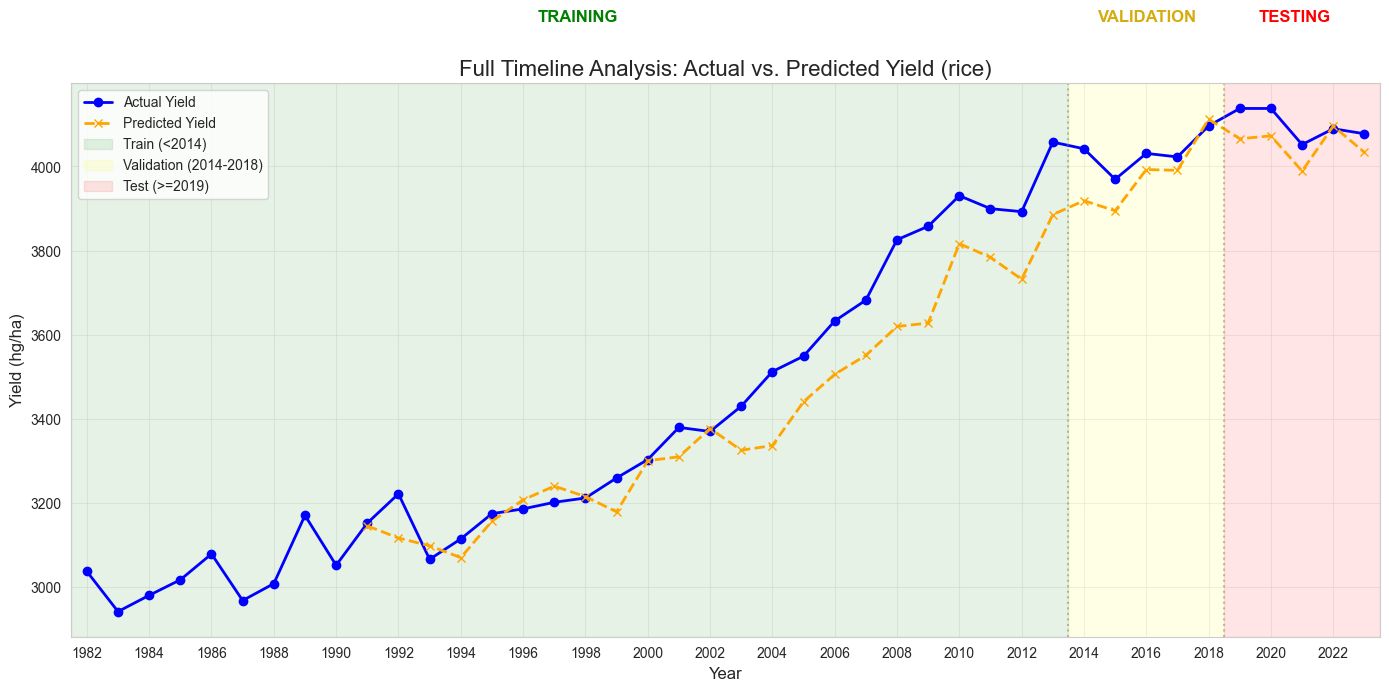

In [23]:
# --- TIMELINE PLOT ---

# 1. Get Predictions for ALL data
# (Need to scale and tensorize everything first)
X_all = scaler.transform(df_model[feature_cols])
X_all_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)

final_model.eval()
with torch.no_grad():
    all_predictions = final_model(X_all_tensor).cpu().numpy().flatten()

# 2. Create DataFrame
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})

# 3. Aggregate by Year
yearly_trend = df_full_trend.groupby('Year').mean()

# 4. Plotting
plt.figure(figsize=(14, 7))

# Lines
plt.plot(yearly_trend.index, yearly_trend['Actual'],
         marker='o', label='Actual Yield', linewidth=2, color='blue')

plt.plot(yearly_trend.index, yearly_trend['Predicted'],
         marker='x', linestyle='--', label='Predicted Yield', linewidth=2, color='orange')

# --- Time Boundaries ---
MIN_YEAR = yearly_trend.index.min()
MAX_YEAR = yearly_trend.index.max()

train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Background Colors ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1,
            label=f'Train (<{TRAIN_END_YEAR})')

plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1,
            label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1})')

plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1,
            label=f'Test (>={VAL_END_YEAR})')

# --- Separators ---
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# --- Text Labels ---
y_max = yearly_trend['Actual'].max()
text_y = y_max * 1.05

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING',
         ha='center', fontsize=12, fontweight='bold', color='green')

plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION',
         ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')

plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING',
         ha='center', fontsize=12, fontweight='bold', color='red')

# --- Labels & Grid ---
plt.title(f'Full Timeline Analysis: Actual vs. Predicted Yield ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

plt.tight_layout()
plt.show()

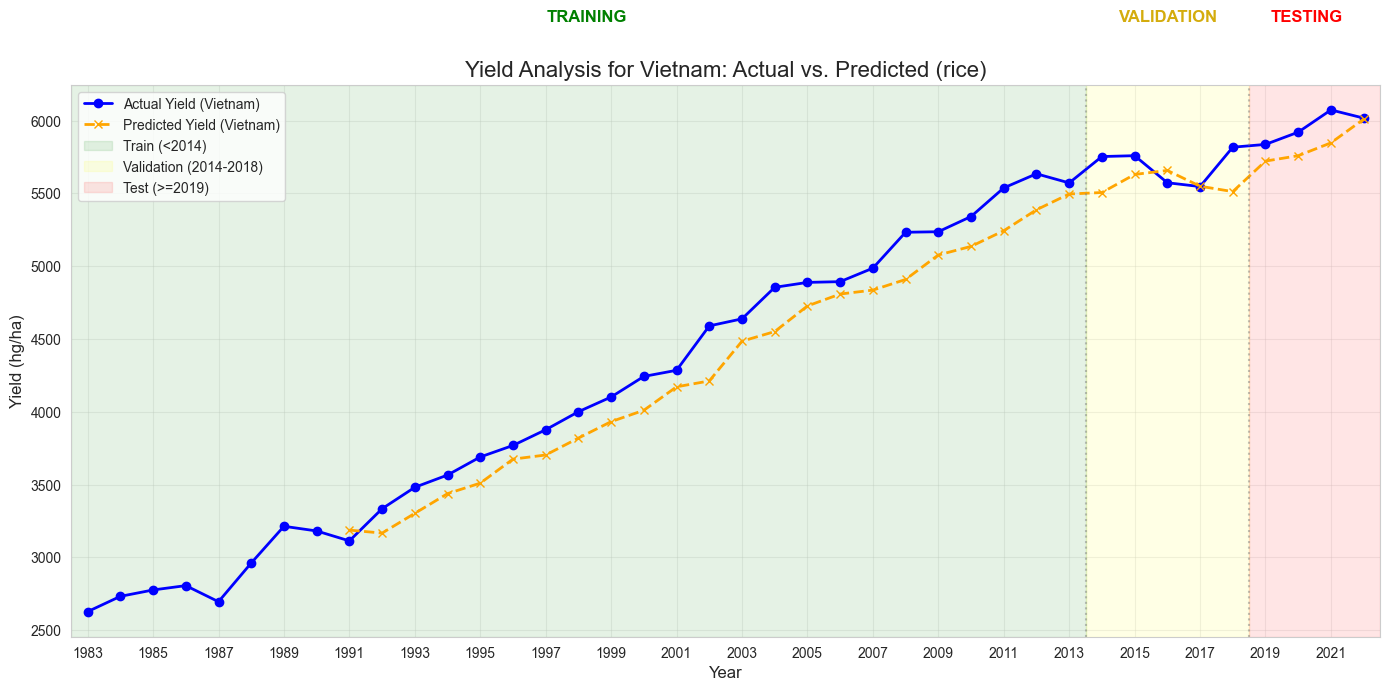

In [24]:
# --- Adding country info ---
df_full_trend['Area'] = df_model['area']

# --- Country-specific Analysis ---
TARGET_COUNTRY = "Vietnam"
df_country = df_full_trend[df_full_trend['Area'] == TARGET_COUNTRY]
country_trend = df_country.groupby('Year')[['Actual', 'Predicted']].mean()

# --- Plotting Country Trend ---
plt.figure(figsize=(14, 7))

# Lines
plt.plot(country_trend.index, country_trend['Actual'],
         marker='o', label=f'Actual Yield ({TARGET_COUNTRY})', linewidth=2, color='blue')
plt.plot(country_trend.index, country_trend['Predicted'],
         marker='x', linestyle='--', label=f'Predicted Yield ({TARGET_COUNTRY})', linewidth=2, color='orange')

# --- Boundaries ---
MIN_YEAR = country_trend.index.min()
MAX_YEAR = country_trend.index.max()
train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Shaded Regions ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1, label=f'Train (<{TRAIN_END_YEAR})')
plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR-1})')
plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1, label=f'Test (>={VAL_END_YEAR})')

# --- Vertical Lines ---
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# --- Labels ---
y_max = country_trend['Actual'].max()
text_y = y_max * 1.1

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING', ha='center', fontsize=12, fontweight='bold', color='green')
plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION', ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')
plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING', ha='center', fontsize=12, fontweight='bold', color='red')

# --- Final Polish ---
plt.title(f'Yield Analysis for {TARGET_COUNTRY}: Actual vs. Predicted ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)
plt.tight_layout()
plt.show()


### 8. Geographic Error Map
Which countries is the model struggling with? Let's map out the errors.

In [25]:
import numpy as np
import pandas as pd
import plotly.express as px

# --- 1. Filter for Test Data ---
mask_test = df_model['year'] >= VAL_END_YEAR
test_context = df_model[mask_test][['area', 'year']]

comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': preds_final_test
})

# Join country info
comparison_df = comparison_df.join(test_context)

# --- 2. Keep only the latest year for each country ---
latest_year = comparison_df.groupby('area')['year'].transform('max')
comparison_df_latest = comparison_df[comparison_df['year'] == latest_year]

print(comparison_df_latest.head())

     Actual_Value  Predicted_Value         area  year
39         4625.0      4447.115723  Afghanistan  2022
89         1790.3      1922.582031      Algeria  2023
129        1172.1      1315.529419       Angola  2023
169        6723.7      6834.323242    Argentina  2023
209        9516.2     10398.273438    Australia  2023


In [26]:
rmse_by_country = (
    comparison_df
    .groupby('area')
    .apply(lambda x: np.sqrt(np.mean((x['Actual_Value'] - x['Predicted_Value'])**2)))
    .reset_index(name='RMSE')
)

# --- 3. Sort (High Error -> Low Error) ---
rmse_by_country_sorted = rmse_by_country.sort_values(by='RMSE', ascending=False)

# --- 4. Show the list ---
print(rmse_by_country_sorted)

           area         RMSE
54      Jamaica  2265.640625
68      Morocco  1717.038548
65    Mauritius  1703.965088
85      Romania  1226.658305
110  Uzbekistan  1091.544429
..          ...          ...
55        Japan    59.032029
34     Eswatini    57.765116
38        Gabon    51.343843
46        Haiti    47.774651
58   Kyrgyzstan    32.160556

[115 rows x 2 columns]


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_3468/2691821451.py:2: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [27]:
import plotly.express as px

# Cleaning up country names for the map
comparison_df['area'] = comparison_df_latest['area'].replace({
    'United_States_of_America': 'United States',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'China, mainland': 'China',
    'Republic_of_Korea': 'South Korea'
})

# Calculating Squared Error
comparison_df['Squared_Error'] = (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) ** 2

# Calculating Error Percentage for RMSPE
comparison_df['Error_Pct'] = ((comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / (comparison_df['Actual_Value'] + 1e-6)) ** 2

# Aggregating stats by country
map_data = comparison_df.groupby('area').agg(
    RMSPE=('Error_Pct', lambda x: np.sqrt(x.mean()) * 100),
    RMSE=('Squared_Error', lambda x: np.sqrt(x.mean())),
    Actual_Mean=('Actual_Value', 'mean'),
    Predicted_Mean=('Predicted_Value', 'mean')
).reset_index()

map_data.rename(columns={'area':'Country'}, inplace=True)

# Plotting the World Map
fig = px.choropleth(
    map_data,
    locations='Country',
    locationmode='country names',
    color='RMSPE',
    color_continuous_scale=['green', 'red'],
    range_color=[0, 50],
    title='Prediction Error by Country (RMSPE)',
    hover_data={
        'RMSPE': ':.2f',
        'RMSE': ':.2f',
        'Actual_Mean': ':.2f',
        'Predicted_Mean': ':.2f'
    }
)

fig.show()


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_3468/3632962943.py:30: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### 9. Feature Importance
Since Neural Nets are basically black boxes, I'm using **Permutation Importance** to figure out which variables actually drive the predictions.

/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_3468/2630137188.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




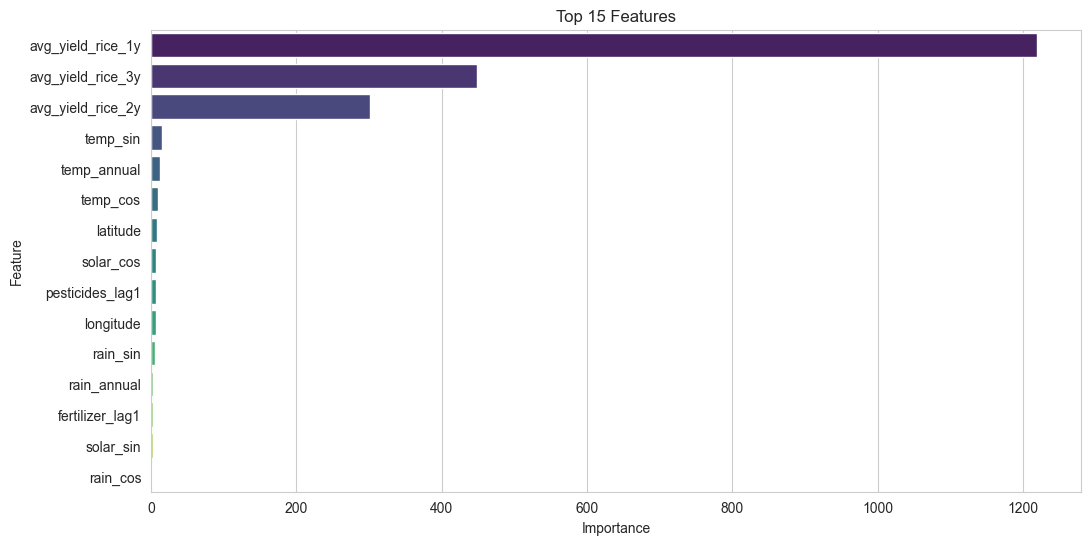

In [28]:
# Helper to make PyTorch work with Scikit-Learn tools
class PyTorchEstimator:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    def fit(self, X, y): pass
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32).to(self.device)
            return self.model(X_t).cpu().numpy().flatten()

estimator = PyTorchEstimator(final_model, device)
res = permutation_importance(estimator, X_val, y_val, scoring='neg_root_mean_squared_error', n_repeats=5)

imps = pd.DataFrame({'Feature': feature_cols, 'Importance': np.abs(res.importances_mean)})
imps = imps.sort_values('Importance', ascending=False).head(15)

sns.barplot(x='Importance', y='Feature', data=imps, palette='viridis')
plt.title('Top 15 Features')
plt.show()